**POZNÁMKA: Tento notebook je určený pre platformu Google Colab. Je však možné ho spustiť (možno s drobnými úpravami) aj ako štandardný Jupyter notebook.** 



In [ ]:
#@title -- Import of Necessary Packages -- { display-mode: "form" }
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from IPython.utils.capture import capture_output
# for kmeans++
from sklearn.utils.extmath import row_norms, stable_cumsum
from sklearn.metrics.pairwise import euclidean_distances
import scipy.sparse as sp

In [ ]:
#@title -- Downloading Data -- { display-mode: "form" }
# also create a directory for storing any outputs
import os
os.makedirs("output", exist_ok=True)

In [ ]:
#@title -- Auxiliary Functions -- { display-mode: "form" }
cluster_colors = ['r', 'g', 'b', 'c', 'm']

class DummyContext:
    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        pass

def scatter_legend(ax, sc, labels, num_colors, color_array,
                   s, edgecolor):
    handles = []
    
    for i in range(num_colors):
        h = mlines.Line2D([0], [0], ls="", color=color_array[i],
                          ms=s, marker=sc.get_paths()[0],
                          markeredgecolor=edgecolor)
        handles.append(h)

    ax.legend(handles=handles, labels=labels)

def plot_data(
    data, cluster_centres=None, color='b', ax=None,
    cluster_colors=cluster_colors,
    edgecolors='k', labels=None,
    center_color='orange', center_size=200,
    legend=True
):
    if ax is None:
        ax = plt.gca()
        
    if labels is None:
        ax.scatter(data[:, 0], data[:, 1], s=50,
                   color=color, edgecolors=edgecolors)
    else:
        c = np.asarray(cluster_colors)[labels]
        
        sc = ax.scatter(data[:, 0], data[:, 1], s=50,
                        c=c, edgecolors=edgecolors,
                        #cmap=plt.cm.get_cmap('category10', np.max(labels)+1)
                       )
        
        if legend:
            nclusts = np.max(labels)+1
            scatter_legend(ax, sc, ['$c_{}$'.format(i) for i in range(nclusts)],
                           nclusts, cluster_colors, s=6, edgecolor='k')
        
    if not cluster_centres is None:
        ax.scatter(cluster_centres[:, 0],
                   cluster_centres[:, 1],
            s=center_size, c=center_color,
            edgecolors=edgecolors)

    ax.grid(ls='--')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_axisbelow(True)

def plot_kmeans_clustering(
   data, k=5, init='from_data', cluster_colors=cluster_colors,
   num_epochs=5, center_color='orange', center_size=200, seed=None,
   show_inline=True, fig_fname="output/kmeans_algo_{}.svg", figsize=(6, 5)
):
    num_clusters = k
    figs = []
    random = np.random.RandomState(seed)
    
    # initialize cluster positions
    if init == 'from_data':
        clust_centers = data[random.choice(range(data.shape[0]), [num_clusters])]
    elif init == 'uniform':
        dmin = data.min(axis=0)
        dmax = data.max(axis=0)
        clust_centers = random.uniform(dmin, dmax, [num_clusters, len(dmin)])
    elif init == 'kmeans++':
        clust_centers = kmeans_plus_plus(data, k, random)
    else:
        raise ValueError("Unknown init '{}'.".format(init))
    
    with DummyContext() if show_inline else capture_output():
        # plot the initial cluster centroids
        fig = plt.figure(figsize=figsize)
        figs.append(fig)
        plot_data(data, clust_centers,
                  center_size=center_size,
                  center_color=center_color)
        plt.show()

        if not fig_fname is None:
            fig.savefig(fig_fname.format(0),
                        bbox_inches='tight', pad_inches=0)
        
        clust_labels = np.zeros(len(data), dtype=np.int)    
        for epoch in range(1, num_epochs+1):
            clust_points = [[] for c in clust_centers]
            
            for ix, x in enumerate(data):
                minic = 0
                mindist = np.inf

                for ic, c in enumerate(clust_centers):
                    dist = np.linalg.norm(x - c)
                    if dist < mindist:
                        mindist = dist
                        minic = ic

                clust_points[minic].append(ix)
                clust_labels[ix] = minic

            # plot the assigment to clusters
            fig = plt.figure()
            figs.append(fig)
            plot_data(data, clust_centers, labels=clust_labels,
                      center_size=center_size, center_color=center_color)
            plt.show()

            if not fig_fname is None:
                fig.savefig(fig_fname.format(epoch),
                            bbox_inches="tight", pad_inches=0)

            # move the clusters
            for ic, cx in enumerate(clust_points):
                clust_centers[ic] = np.mean(data[cx, :], axis=0)

    return figs

def kmeans_plus_plus(X, n_clusters, random_state, n_local_trials=None):
    x_squared_norms = row_norms(X, squared=True)
    n_samples, n_features = X.shape

    centers = np.empty((n_clusters, n_features), dtype=X.dtype)

    assert x_squared_norms is not None, 'x_squared_norms None in _k_init'

    # Set the number of local seeding trials if none is given
    if n_local_trials is None:
        # This is what Arthur/Vassilvitskii tried, but did not report
        # specific results for other than mentioning in the conclusion
        # that it helped.
        n_local_trials = 2 + int(np.log(n_clusters))

    # Pick first center randomly
    center_id = random_state.randint(n_samples)
    if sp.issparse(X):
        centers[0] = X[center_id].toarray()
    else:
        centers[0] = X[center_id]

    # Initialize list of closest distances and calculate current potential
    closest_dist_sq = euclidean_distances(
        centers[0, np.newaxis], X, Y_norm_squared=x_squared_norms,
        squared=True)
    current_pot = closest_dist_sq.sum()

    # Pick the remaining n_clusters-1 points
    for c in range(1, n_clusters):
        # Choose center candidates by sampling with probability proportional
        # to the squared distance to the closest existing center
        rand_vals = random_state.random_sample(n_local_trials) * current_pot
        candidate_ids = np.searchsorted(stable_cumsum(closest_dist_sq),
                                        rand_vals)
        # XXX: numerical imprecision can result in a candidate_id out of range
        np.clip(candidate_ids, None, closest_dist_sq.size - 1,
                out=candidate_ids)

        # Compute distances to center candidates
        distance_to_candidates = euclidean_distances(
            X[candidate_ids], X, Y_norm_squared=x_squared_norms, squared=True)

        # update closest distances squared and potential for each candidate
        np.minimum(closest_dist_sq, distance_to_candidates,
                   out=distance_to_candidates)
        candidates_pot = distance_to_candidates.sum(axis=1)

        # Decide which candidate is the best
        best_candidate = np.argmin(candidates_pot)
        current_pot = candidates_pot[best_candidate]
        closest_dist_sq = distance_to_candidates[best_candidate]
        best_candidate = candidate_ids[best_candidate]

        # Permanently add best center candidate found in local tries
        if sp.issparse(X):
            centers[c] = X[best_candidate].toarray()
        else:
            centers[c] = X[best_candidate]

    return centers

## Zhlukovanie a algoritmus $k$-means

Zhlukovanie je jednou z úloh nekontrolovaného učenia. Metódy zhlukovania pomáhajú identifikovať zhluky bodov v dátach. Zhlukom sa vo všeobecnosti rozumie taká štruktúra dát, kde dátové body zo zhluku sú si navzájom bližšie (v zmysle nejakej miery) než oproti bodom z iných zhlukov.

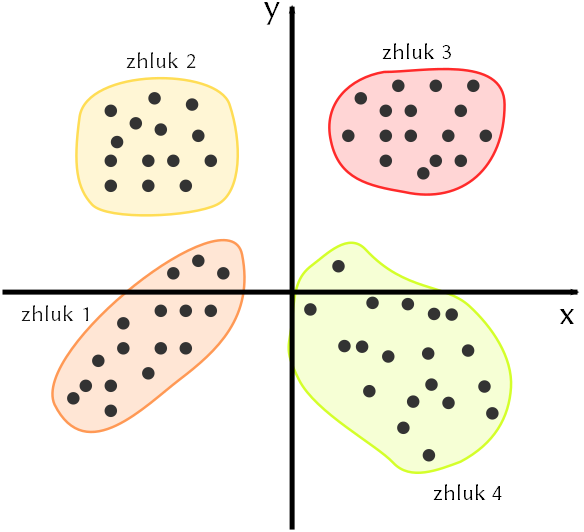

Zatiaľ čo v 1 a 2-rozmerných dátach dokážeme typicky zhluky ľahko identifikovať vizuálne, pri mnohorozmerných dátach je to zložitejšie a je potrebné použiť metódy, ktoré vedia zhluky nájsť automaticky.

Metódy zhlukovania možno rozdeliť na dva hlavné typy podľa štruktúry ich výstupu [[mmds2014]](#mmds2014):

* **Priraďovanie bodov**  (angl. point-assignment methods): Každý bod z dátovej množiny sa na základe relatívnych vzdialeností medzi bodmi (určených v zmysle nejakej miery vzdialenosti) priradí do určitého zhluku. Metóda navracia identifikátor zhluku pre každý bod.
* **Hierarchické metódy**  (angl. hierarchical methods): Namiesto priraďovania bodov do zhlukov, metóda body zoradí do hierarchickej štruktúry. Táto štruktúra sa následne dá na ľubovoľnej úrovni rozstrihnúť, čím vznikne priradenie do zhlukov rovnakého typu ako vedia poskytnúť metódy priraďovania bodov. Diagram tejto hierarchickej štruktúry sa nazýva **dendrogram** .
Ďalší spôsob ako rozdeliť metódy zhlukovanie je podľa toho koľko ráz berú do úvahy každý bod [[mmds2014]](#mmds2014):

* **Iteratívne metódy** : potrebujú cez body iterovať niekoľko ráz;
* **Skenové metódy** : stačí im cez dátovú množinu prejsť jeden raz.
Rozdiel medzi týmito prístupmi je veľmi markantný najmä pri práci s veľmi veľkými dátovými množinami, ktoré sa nezmestia do pamäte, pretože opakované načítavanie dát z disku do pamäte môže mať drastický dopad na efektívnosť výpočtov.
My sa budeme v tomto notebook-u venovať princípom jednej z najjednoduchších metód zhlukovania, známej ako $k$-means ($k$ stredných hodnôt), a ilustrujeme si ich na príklade.

### $k$-means: princíp

Počet zhlukov $k$, ktorý má algoritmus $k$-means identifikovať, je potrebné definovať vopred. V prvom kroku algoritmu sa nejakým stochastickým spôsobom inicializujú pozície stredov všetkých $k$ zhlukov (napr. sa vyberú s rovnomerného rozdelenia). Následne sa iteratívne premiestňujú tak, aby sa postupne minimalizovali vzdialenosti medzi stredom zhluku a bodmi, ktoré do neho patria. Názov algoritmu sa odkazuje práve na počet zhlukov $k$ a na stredy zhlukov, ktoré sa určujú ako stredná hodnota bodov (means).

Formálnejšie: predpokladajme, že máme dátovú množinu $X = \{x_i\}$, obsahujúcu $N$ bodov z $D$-rozmerného priestoru a chceme ich rozdeliť do $k$ zhlukov. Zhluky označíme $C = \{c_j\}$. Stred zhluku $c_j$ označíme $\mu_j$. Súčet štvorcov vzdialeností medzi stredom zhluku $c_j$ a jeho jednotlivými bodmi $x_i \in c_j$ môžeme vyjadriť ako [[jain2010data]](#jain2010data)
\begin{equation}
J(c*j) = \sum* {x_i \in c_j} |x_i - \mu_j|^2,
\end{equation}
kde $\|x_i - \mu_j\|$ je euklidovská vzdialenosť medzi vektormi $x_i$ a $\mu_j$.

Cieľ $k$-means algoritmu vieme potom vyjadriť ako minimalizáciu $J(c_j)$ naprieč všetkými zhlukmi $c_j$. Môžeme teda definovať sumárne kritérium [[jain2010data]](#jain2010data)
\begin{equation}
J(C) = \sum*{j=1}^{k} \sum* {x_i \in c_j} | x_i - \mu_j |^2,
\end{equation}
ktoré sa budeme snažiť minimalizovať.

Nájsť globálne minimum tejto funkcie je však nanešťastie NP-ťažká úloha (náročnosť výpočtu neprijateľne zle škáluje s veľkosťou úlohy; viac o NP inde). Preto sa uspokojíme aj s algoritmom $k$-means, ktorý konverguje len k jej lokálnemu a nie globálnemu minimu [[jain2010data]](#jain2010data). Jeho jednotlivé kroky sumarizuje nasledujúci pseudokód:

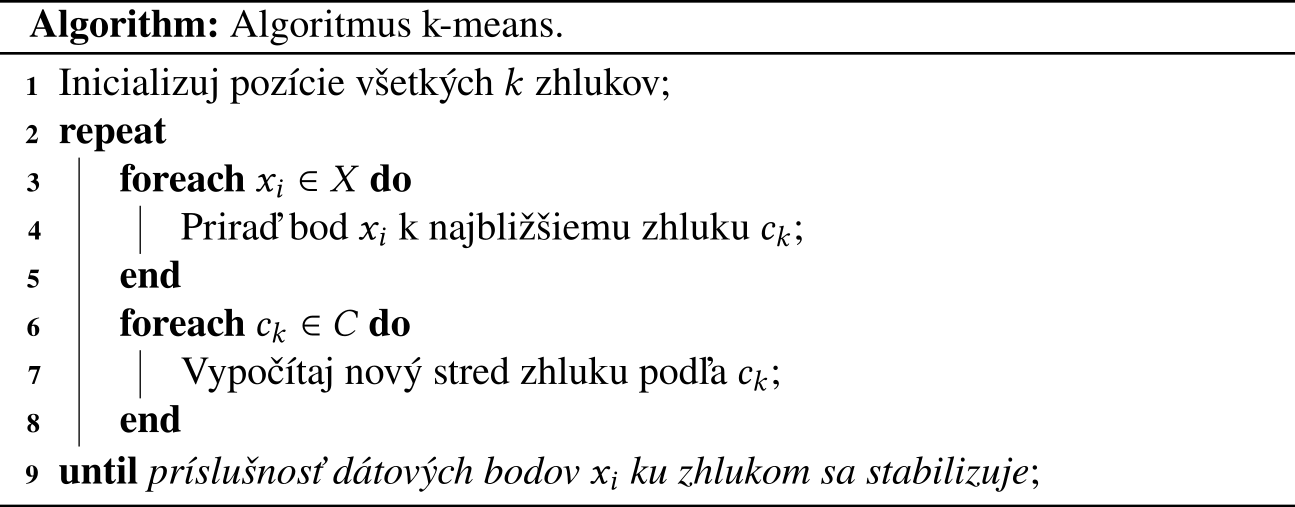

#### Priradenie bodov

Ako vidno, $k$-means po inicializácii už len cyklicky alternuje medzi dvomi krokmi: v prvom priradí každý bod $x_i$ do najbližšieho zhluku $c_j$. Formálne možno priradenie vyjadriť takto:
\begin{equation}
c_j = \underset{c_j}{\mathrm{argmin}} | \mu_j - x_i |^2,
\end{equation}
t.j. nájde sa ten zhluk $c_j$, ktorého stred je k bodu $x_i$ najbližšie v zmysle euklidovskej vzdialenosti.

#### Aktualizácia stredov

V druhom kroku sa nanovo prepočítajú stredy všetkých zhlukov: určia sa ako priemer (empirická stredná hodnota) všetkých bodov, ktoré do zhluku patria, t.j.:
\begin{equation}
\mu_j \leftarrow \frac{1}{|c*j|} \sum* {x_i \in c_j} x_i,
\end{equation}
kde $|c_j|$ je kardinalita zhluku $c_j$, t.j. celkový počet bodov $x_i \in c_j$, ktoré doňho patria.

Kroky sa opakujú, kým sa príslušnosť bodov k zhlukom nestabilizuje [[jain2010data]](#jain2010data).

### Syntetické dáta

Aby sme mohli postup zhlukovanie ľahko vizualizovať, vytvoríme si syntetickú 2-rozmernú dátovú množinu s 5 veľmi jasnými zhlukmi pomocou funkcie `datasets.make_blobs` z balíčka `sklearn` a hneď si ju aj zobrazíme.



In [ ]:
data, labels = datasets.make_blobs(
    n_samples=600, random_state=3,
    cluster_std=0.75, centers=5)

fig = plt.figure(figsize=(6, 5))
plot_data(data)

### $k$-means: ilustrácia

V tejto časti spustíme $k$-means na dátovej množine. V nasledujúcej bunke vygenerujeme obrázky a následne si ich jeden po druhom zobrazíme a prejdeme si všetky jednotlivé kroky.



In [ ]:
figs = plot_kmeans_clustering(data, seed=5, num_epochs=4, show_inline=False)

#### Inicializácia stredov zhlukov

V prvok kroku vyberieme náhodné body z dátovej množiny a použijeme ich ako počiatočné stredy zhlukov.



In [ ]:
figs[0]

#### Priradenie do zhlukov

Následne prejdeme cez všetky body a každý z nich priradíme k najbližšiemu zhluku (tu indikované rôznymi farbami).



In [ ]:
figs[1]

#### Aktualizácia stredov zhlukov

Potom ako každý bod priradíme k určitému zhluku, prejdeme cez jednotlivé body každého zhluku, vypočítame ich priemer a presunieme tam stred zhluku.



In [ ]:
figs[2]

#### Iteratívne opakovanie

Kroky priradenia do zhlukov a aktualizácie stredov zhlukov opakujeme iteratívne dovtedy, kým sa priradenia nestabilizujú.



In [ ]:
display(figs[3])
display(figs[4])

### Dobrá inicializácia je kľúčová

Pozície počiatočných stredov zhlukov majú dramatický dopad na výsledky: ak sa zvolia nešťastne, lokálne minimum nájdené algoritmom $k$-means môže byť silno suboptimálne, ako to ilustruje nasledujúci príklad.



In [ ]:
figs = plot_kmeans_clustering(data, seed=2, num_epochs=4,
                              fig_fname='output/kmeans_bad_init_{}.svg')

#### $k$-means++

V praxi preto praktické implementácie algoritmu $k$-means typicky používajú sofistikovanejšie inicializačné metódy ako je napr. $k$-means++ (čo je predvolená inicializačná metóda v rámci balíčka `scikit-learn`), ktorá zabezpečuje, aby počiatočné stredy zhlukov boli rozmiestnené rovnomernejšie.

Prístup $k$-means++ predpisuje konkrétne nasledujúci postup [[arthur2007k]](#arthur2007k):

# Prvý stred zhluku sa umiestni na pozíciu rovnomerne náhodne zvoleného bodu z dátovej množiny $X$.
# Nasledujúce stredy zhlukov sa generujú jeden po druhom. Znovu sa umiestňujú na pozície náhodne zvolených bodov z dátovej množiny, ale pravdepodobnosť voľby bodu je teraz určená vzťahom
$$
p(x) = \frac{\Delta(x)^2}{\sum_{x_i \in X} \Delta(x_i)^2},
$$kde $\Delta(x)$ označuje vzdialenosť z dátového bodu $x$ k stredu najbližšieho už inicializovaného zhluku.

#### $k$-means++: príklad

Dopady tejto inicializačnej metódy vidno nižšie, v príklade, kde generujeme viacero verzí počiatočných stredov zhlukov. Všimnite si, že počiatočné stredy sú teraz už na začiatku primerane rozptýlené medzi zhlukmi – hoci stále bude ešte potrebných niekoľko iterácií $k$-means algoritmu, kým sa priradenia bodov stabilizujú.



In [ ]:
fix, axes = plt.subplots(3, 3, figsize=(11, 9))
rand_state = np.random.RandomState(2)

for ax in axes.reshape(-1):
    cluster_init = kmeans_plus_plus(data, 5, rand_state)
    plot_data(data, cluster_init, ax=ax)
    
plt.tight_layout()

### Neeuklidovské priestory a $k$-medoids

Nie všetky priestory, z ktorých berieme dátové množiny, sú euklidovské. Pre algoritmus $k$-means táto skutočnosť predstavuje problém, pretože v takých priestoroch nemusí dávať priemerovanie bodov zmysel a jeho výsledkom nemusí dokonca ani byť validný bod z priestoru. Ako jednoduchý príklad môžeme použiť priestor binárnych reťazcov, napr. reťazce $001$ a $101$ reprezentujúce určité konkrétne informácie.

Každý bit v týchto reťazcoch nesie určitý význam. Ak by sme po prvkoch vypočítali priemer týchto dvoch reťazcov, nedávalo by to zmysel. Výsledkom by bolo $0.5, 0, 0.5$, čo ani nie je binárny reťazec. Tiež platí, že tieto binárne reťace nemôžeme jednoducho interpretovať ako čísla a vypočítať priemer z nich. Povedali sme už predsa, že reťazce nekódujú jednoducho číselné hodnoty: každý bit reťazca nesie svoj špecifický význam.

#### $k$-medoids

Znamená to teda, že zhlukovanie je možné realizovať len v euklidovských priestoroch? Našťastie nie. Ak vieme v danom priestore merať vzdialenosti, dokážeme pre dvojice bodov stále zadefinovať nejakú mieru podobnosti. Čo potrebujeme vyriešiť je, ako definovať stredy zhlukov bez toho, aby sme potrebovali body priemerovať (rátať empirické stredné hodnoty zhlukov).

Algoritmus $k$-medoids je prístup, ktorý funguje presne rovnako ako algoritmus $k$-means, len s tým rozdielom, že namiesto stredných hodnôt využíva tzv. medoidy (nazývané aj clustroids). Medoid predstavuje bod z pôvodnej dátovej množiny (takže je zaručené, že ide o validný bod), ktorý je (v nejakom zmysle) pre daný zhluk najprostrednejší a teda sa dá použiť na reprezentáciu zhluku [[elem_stat]](#elem_stat).

Existuje viacero spôsobov ako medoidy definovať, napr. [[mmds2014]](#mmds2014):

* bod s najmenšou celkovou vzdialenosťou voči ostatným bodom zo zhluku;
* bod s najmenšou maximálnou vzdialenosťou voči inému bobu zo zhluku;
* ...
Aby sme identifikovali medoid zhluku, musia sa porovnať vzdialenosti medzi všetkými bodmi, takže algoritmus $k$-medoids je výpočtovo náročnejší než algoritmus $k$-means [[elem_stat]](#elem_stat).



### References

<a id="jain2010data">[jain2010data]</a> Jain, A.K., 2010. Data clustering: 50 years beyond K-means. Pattern recognition letters, 31(8), pp.651-666.

<a id="arthur2007k">[arthur2007k]</a> Arthur, D. and Vassilvitskii, S., 2006. k-means++: The advantages of careful seeding. Stanford.

<a id="mmds2014">[mmds2014]</a> Rajaraman, A. and Ullman, J.D., 2011. Mining of massive datasets. Cambridge University Press. URL: <http://infolab.stanford.edu/~ullman/mmds/book.pdf>.

<a id="elem_stat">[elem_stat]</a> Friedman, J., Hastie, T. and Tibshirani, R., 2001. The elements of statistical learning (Vol. 1, No. 10). New York: Springer series in statistics. Ed. 2.

